In [86]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [87]:
conn = sqlite3.connect('../../../../data/FPA_FOD_20170508.sqlite')

In [88]:
df_fires = pd.read_sql_query("SELECT * FROM 'Fires'", conn)
# df_fires = pd.read_sql_query("SELECT FIRE_YEAR,STAT_CAUSE_DESCR,LATITUDE,LONGITUDE,STATE,DISCOVERY_DATE,FIRE_SIZE FROM 'Fires'", conn)


## Data Quality

In [89]:
df_fires.info()

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   OBJECTID                    int64  
 1   FOD_ID                      int64  
 2   FPA_ID                      object 
 3   SOURCE_SYSTEM_TYPE          object 
 4   SOURCE_SYSTEM               object 
 5   NWCG_REPORTING_AGENCY       object 
 6   NWCG_REPORTING_UNIT_ID      object 
 7   NWCG_REPORTING_UNIT_NAME    object 
 8   SOURCE_REPORTING_UNIT       object 
 9   SOURCE_REPORTING_UNIT_NAME  object 
 10  LOCAL_FIRE_REPORT_ID        object 
 11  LOCAL_INCIDENT_ID           object 
 12  FIRE_CODE                   object 
 13  FIRE_NAME                   object 
 14  ICS_209_INCIDENT_NUMBER     object 
 15  ICS_209_NAME                object 
 16  MTBS_ID                     object 
 17  MTBS_FIRE_NAME              object 
 18  COMPLEX_NAME                object 
 19  FIRE_YE

In [90]:
df_fires.iloc[0]

OBJECTID                                                                      1
FOD_ID                                                                        1
FPA_ID                                                               FS-1418826
SOURCE_SYSTEM_TYPE                                                          FED
SOURCE_SYSTEM                                                       FS-FIRESTAT
NWCG_REPORTING_AGENCY                                                        FS
NWCG_REPORTING_UNIT_ID                                                  USCAPNF
NWCG_REPORTING_UNIT_NAME                                 Plumas National Forest
SOURCE_REPORTING_UNIT                                                      0511
SOURCE_REPORTING_UNIT_NAME                               Plumas National Forest
LOCAL_FIRE_REPORT_ID                                                          1
LOCAL_INCIDENT_ID                                                        PNF-47
FIRE_CODE                               

In [91]:
df_fires.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


### Set Index

In [92]:
df_fires.set_index("OBJECTID", inplace=True)

In [93]:
df_fires.index.is_unique

True

### Missing Values

In [94]:
df_fires.isna().any()

FOD_ID                        False
FPA_ID                        False
SOURCE_SYSTEM_TYPE            False
SOURCE_SYSTEM                 False
NWCG_REPORTING_AGENCY         False
NWCG_REPORTING_UNIT_ID        False
NWCG_REPORTING_UNIT_NAME      False
SOURCE_REPORTING_UNIT         False
SOURCE_REPORTING_UNIT_NAME    False
LOCAL_FIRE_REPORT_ID           True
LOCAL_INCIDENT_ID              True
FIRE_CODE                      True
FIRE_NAME                      True
ICS_209_INCIDENT_NUMBER        True
ICS_209_NAME                   True
MTBS_ID                        True
MTBS_FIRE_NAME                 True
COMPLEX_NAME                   True
FIRE_YEAR                     False
DISCOVERY_DATE                False
DISCOVERY_DOY                 False
DISCOVERY_TIME                 True
STAT_CAUSE_CODE               False
STAT_CAUSE_DESCR              False
CONT_DATE                      True
CONT_DOY                       True
CONT_TIME                      True
FIRE_SIZE                   

### Duplicate Rows

In [95]:
df_fires.duplicated().any()

False

In [96]:
plt.style.use('ggplot')

### Causes of Wildfires

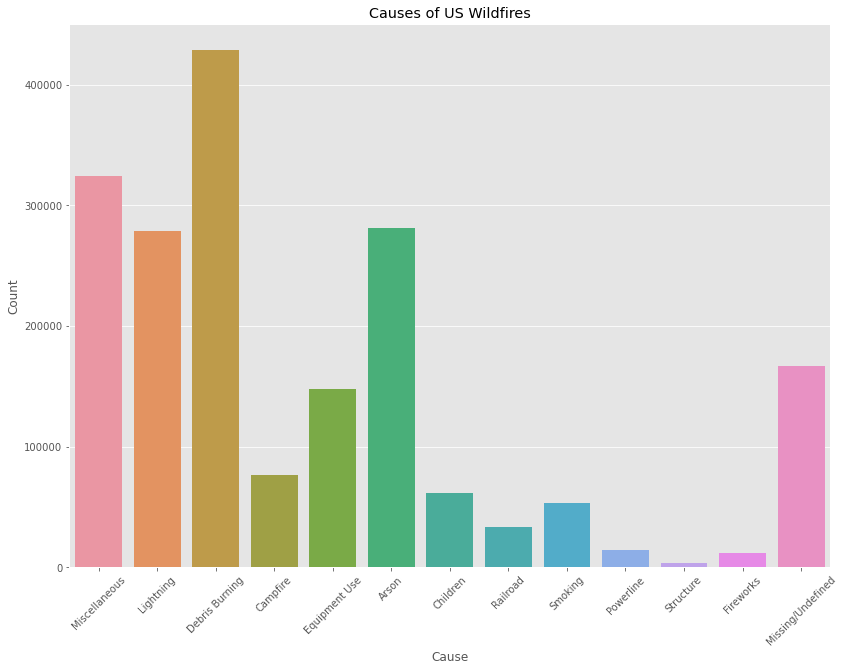

In [97]:
fig_0 = plt.figure(1, figsize=(30, 10))

chart_1 = fig_0.add_subplot(121)

sns.countplot(x="STAT_CAUSE_DESCR", data=df_fires, ax=chart_1)
chart_1.set_title('Causes of US Wildfires')
chart_1.set_xlabel('Cause')
chart_1.set_ylabel('Count')
chart_1.set_xticklabels(chart_1.get_xticklabels(), rotation=45)

plt.show()

In [98]:
# df_fires.head().to_csv("../../../../data/FPA_FOD_20170508_SAMPLE.CSV", index=False)

### Converting Julian to calendar date using pandas

 - https://stackoverflow.com/questions/63434276/converting-julian-to-calendar-date-using-pandas

In [99]:
%%time
df_fires["DISCOVERY_DATETIME"] = pd.to_datetime(df_fires["DISCOVERY_DATE"], unit='D', origin='julian')


CPU times: user 155 ms, sys: 19.1 ms, total: 174 ms
Wall time: 180 ms


In [100]:
df_fires["DISCOVERY_TIME"].head()

OBJECTID
1    1300
2    0845
3    1921
4    1600
5    1600
Name: DISCOVERY_TIME, dtype: object

In [101]:
df_fires['DISCOVERY_DATEYEAR'] = pd.DatetimeIndex(df_fires["DISCOVERY_DATETIME"]).year

### Annual Count of US Wildfires


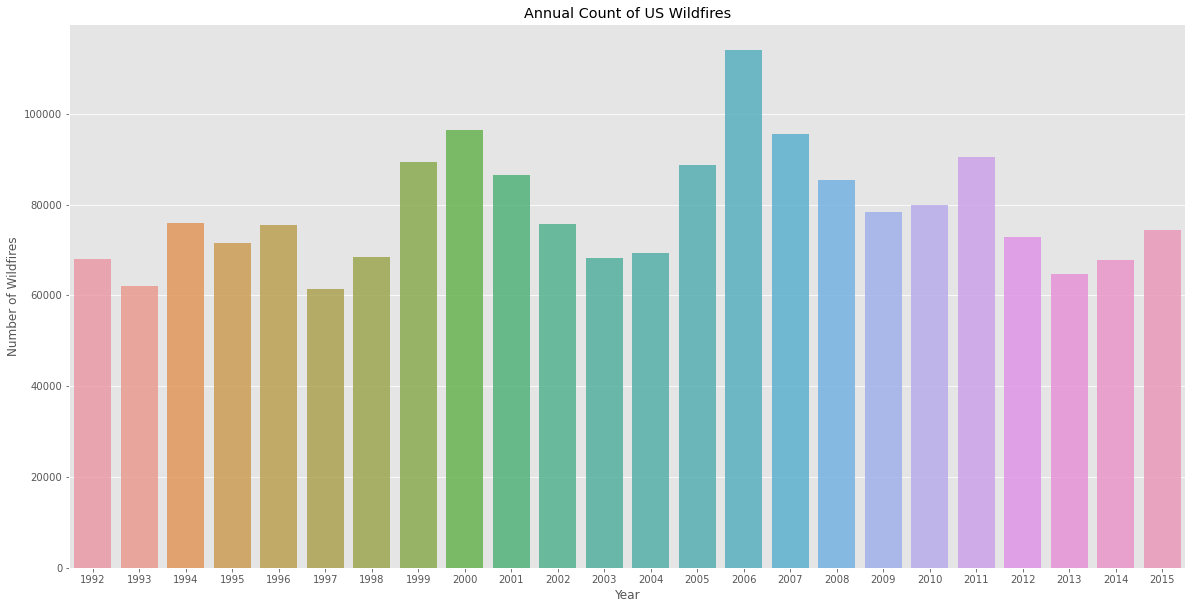

In [102]:

year_count  = df_fires['DISCOVERY_DATEYEAR'].value_counts().sort_index()
plt.figure(figsize=(20, 10))
sns.barplot(year_count.index, year_count.values, alpha=0.8)
plt.title('Annual Count of US Wildfires')
plt.ylabel('Number of Wildfires')
plt.xlabel('Year')
plt.show()